# EnigmaNet: A Neural Network Framework for Eplipesy Classification
### This is a script that uses Keras to predict epilepsy outcomes

## Script Details
This script is designed to run with the following configuration:
* Keras
* TensorFlow backend
* PlaidML backend (if using Radeon GPU)
* Tabular data (Excel or CSVs)

## Dependencies
Run the following command to pip install all dependencies
```
pip install numpy pandas sklearn matplotlib scipy keras_tqdm
```

Also install NeuroCombat at https://github.com/ncullen93/neuroCombat

## Path to Data
Define path to tabular data


In [1]:
csvPath = '/Users/sid/Documents/Projects/Enigma-ML/Dataset/T1/all.csv'

## Define Script Parameters
Define parameters that control script flow

In [2]:
classCol = 'Dx'             # Class labels
siteCol = 'Site'            # Site or scanner column name
dBegin = 'ICV'              # Column where data begins
dEnd = 'R_insula_surfavg'   # Column where data ends
cBegin = 'Site'             # Column where covariates/demographics begin
cEnd = 'Sex'                # Column where covariates/demographics end
fillmissing = True          # Fill missing?
harmonize = True            # Run ComBat harmonization?
scaleData = True            # Rescale data?
dataSplit = 0.10            # Percent of data to remove for validation
nEpochs = 250              # Training number of epochs
bSize = 30                  # Training batch size
plotType = 'Normal'         # Type of ComBat graphs to save ('Histogram' or 'Normal')

## Define ComBat Harmonization Parameters
Python implementation of ComBat is currently being used, which can be found at https://github.com/ncullen93/neuroCombat

In [3]:
# Combat Variables
if harmonize:
    batchVar = 'Site'           # Batch effect variable
    discreteVar = ['Dx','Sex']  # Variables which are categorical that you want to predict
    continuousVar = ['Age']     # Variables which are continuous that you want to predict

## Import Required Modules
Import all modules required to process the script

In [4]:
import numpy as np
import pandas as pd
from neuroCombat import neuroCombat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import sklearn.metrics as skm
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
import scipy.stats
import random
import os

Using TensorFlow backend.


## Dependent Function
Functions that the scrips will depend on

In [5]:
def classfill(dFrame, classCol, siteCol, idxRange):
    """Fills missing values with means of a class
    
    Inputs
    ------
    dFrame:   Pandas dataframe to process (type: dataframe)
            
    classCol: String indicating dataframe column name containing class information

    siteCol:  String indicating dataframc column name containing class information
    
    idxRange: 2x1 vector indicating lower and upper bound of data to fill in dataframe
              idxRange[0] is lower bound
              idxRange[1] is upper bound

    Returns
    -------
    data:     Dataframe will all missing values filled
    """
    uniqClass = dFrame[classCol].unique()                   # All unique classes
    uniqSites = dFrame[siteCol].unique()                    # All unique sites
    print('...found ' + str(uniqClass.size) + ' classes across ' + str(uniqSites.size) + ' sites')
    print('...filling missing data with class means')
    data = dFrame.loc[:, idxRange[0]:idxRange[1]]           # Extract all numerical value from 'dBegin' onwards
    for site in uniqSites:
        siteIdx = dFrame.loc[:, siteCol] == site            # Index where site is uniqSite = site
        for cls in uniqClass:
            classIdx = dFrame.loc[:, classCol] == cls       # Index where class is uniqClass = cls
            idx = siteIdx & classIdx                        # Index where both class and site indexes are true
            for col in range(len(data.columns)):            # Iterate along each column
                nanIdx = data.iloc[: ,col].isnull()         # Index where NaNs occur per feature
                nanIdx_i = nanIdx & idx                     # Index where NaNs occur per feauture, per site, per class
                if np.sum(nanIdx_i) > 0:
                    mean = np.nanmean(data.iloc[:, col][idx]) # Compute mean of non-NaNs# If there are any Nans...
                    data.iloc[:, col][nanIdx_i] = mean      # Replace NaNs with mean
    dFrame.loc[:, idxRange[0]:idxRange[1]] = data           # Substitute dataframe with corrected data
    return dFrame

def minorityclass(dFrame, classCol):
    """Returns the minority class label in a set of binary class labels
    Inputs
    ------
    dFrame: Pandas Dataframe containing tabular data

    classCol: Column label containing class information (string)

    Returns
    -------
    minorClass: String depicting minor class

    disparity: Integer indicating disparity between minor and major classes
    """
    uniqClass = dFrame[classCol].unique()  # All unique classes
    nClass = np.zeros((uniqClass.shape), dtype=int)
    for i, classVal in enumerate(uniqClass):
        nClass[i] = np.sum(dFrame.loc[:, classCol] == classVal)
    minorIdx = np.argmin(nClass)
    minorClass = uniqClass[minorIdx]
    majorIdx = np.argmax(nClass)
    disparity = nClass[majorIdx] - nClass[minorIdx]
    return minorClass, disparity

## Load Files and Manipulate
Load tabular data and prime it for deep learning
### Load Data and Perform Sanity Check
Load CSV into a Pandas Dataframe, then obtain all unique classes to ensure only relevant classes are present.

In [6]:
dFrame = pd.read_csv(csvPath)           # Create Dataframe

# Integrity check
print('Found classes: ' + str(dFrame.loc[:, 'Dx'].unique()))

Found classes: [1 0]


### Manipulate Data
This section fills in missing values and performs ComBat harmonization across multiple sites. It is necessary to fill in missing data prior to harminization as a prerequisity to running ComBat.

In [7]:
# Fill missing
if fillmissing:
    dFrame = classfill(dFrame, classCol, siteCol, [dBegin, dEnd])
else:
    print('...skip fill missing')

# Run combat
if harmonize:
    cData = neuroCombat(data=dFrame.loc[:,dBegin:dEnd],
                          covars=dFrame.loc[:,cBegin:cEnd],
                          batch_col=batchVar,
                          discrete_cols=discreteVar,
                          continuous_cols=continuousVar)

data = np.array(dFrame.loc[:, dBegin:dEnd])     # Preserve non-harmonized data

# Scale data
scaler = StandardScaler()   # Initialize scaler
if scaleData:
    if harmonize:
        cData = scaler.fit_transform(cData)
    data = scaler.fit_transform(data)

...found 2 classes across 16 sites
...filling missing data with class means
Creating design matrix..
Standardizing data across features..
Fitting L/S model and finding priors..
Finding parametric adjustments..
Final adjustment of data..


## Split Data for Training and Evaluation
Data needs to be split for trianing and evaluation

In [8]:
if harmonize:
    X_train, X_test, y_train, y_test = train_test_split(cData, dFrame.loc[:, classCol],
                                                        test_size=dataSplit,
                                                        random_state=42,
                                                        stratify=dFrame.loc[:, classCol])
else:
    X_train, X_test, y_train, y_test = train_test_split(data, dFrame.loc[:, classCol],
                                                        test_size=dataSplit,
                                                        random_state=42,
                                                        stratify=dFrame.loc[:, classCol])

## Build Model and Train
A perceptron is constructed here for training

In [9]:
# Choose whether data/labels or X_Train,y_train
dataIn = X_train
labelsIn = y_train

# Initialising the ANN
model = Sequential()

# Adding the Single Perceptron or Shallow network
model.add(Dense(output_dim=64, init='uniform', activation='relu', input_dim=dataIn.shape[1]))
# Adding dropout to prevent overfitting
model.add(Dropout(p=0.1))
# Adding hidden layers
#model.add(Dense(64, kernel_initializer='normal', activation='relu'))
#model.add(Dense(16, kernel_initializer='normal', activation='relu'))
#model.add(Dense(4, kernel_initializer='normal', activation='relu'))
# Adding the output layer
model.add(Dense(output_dim=1, init='uniform', activation='sigmoid'))
# criterion loss and optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Fitting the ANN to the Training set
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(dataIn, labelsIn,
                    batch_size=bSize,
                    epochs=nEpochs,
                    verbose=False,
                    callbacks=[TQDMNotebookCallback()])

W0813 15:15:15.057974 4688074176 deprecation_wrapper.py:119] From /Users/sid/miniconda3/envs/deep/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/Users/sid/miniconda3/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=157, units=64, kernel_initializer="uniform")`
  if __name__ == '__main__':
W0813 15:15:15.073137 4688074176 deprecation_wrapper.py:119] From /Users/sid/miniconda3/envs/deep/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 15:15:15.076630 4688074176 deprecation_wrapper.py:119] From /Users/sid/miniconda3/envs/deep/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.

## Evaluation of Model
Evaluation based on holdout data. A confusion matrix is printed out

In [10]:
# Predicting the Test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
accuracy = skm.accuracy_score(y_test, y_pred)
precision = skm.precision_score(y_test, y_pred)
recall = skm.recall_score(y_test, y_pred)
kappa = skm.cohen_kappa_score(y_test, y_pred)
resultStr = '''----------Validation Results----------
Confusion Matrix: 
{0}
    Accuracy:  {1:0.2f}%
    Precision: {2:0.2f}%
    Recall:    {3:0.2f}%
    Kappa:     {4:0.2f}%
--------------------------------------
'''.format(np.array(cm), accuracy*100, precision*100, recall*100, kappa*100)
print(resultStr)

----------Validation Results----------
Confusion Matrix: 
[[ 93  33]
 [ 46 106]]
    Accuracy:  71.58%
    Precision: 76.26%
    Recall:    69.74%
    Kappa:     43.17%
--------------------------------------



## Create Plots
Create and save plots in work directory

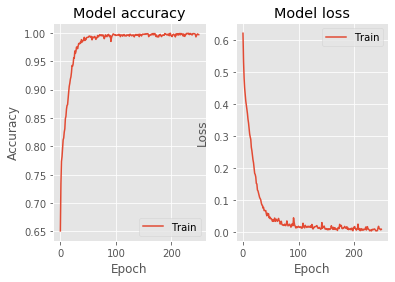

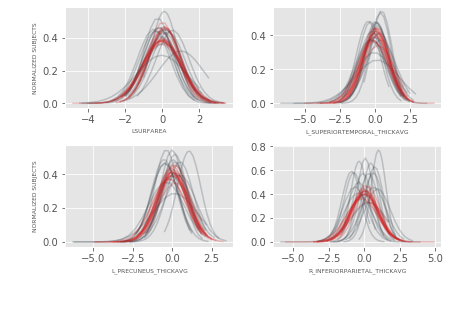

In [11]:
# Form Graph Path
pwd = os.getcwd()
savePathModel = os.path.join(pwd, 'model_fit.png')
savePathComBat = os.path.join(pwd, 'combat.png')

# Plot training & validation accuracy values
with plt.style.context('ggplot'):
    plt.subplot(121)
    plt.plot(history.history['acc'])
    # plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='lower right')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig(savePathModel, dpi=600)

# Plot ComBat before & after
if harmonize:
    szSubPlot = 4                                                                   # Number of features to plot
    nBins = 20                                                                      # Number of bins

    uniqSites = dFrame.loc[:,'Site'].unique()
    with plt.style.context('ggplot'):                                               # Plotting style
        fig, axs = plt.subplots(np.sqrt(szSubPlot).astype(int), np.sqrt(szSubPlot).astype(int))
        for axsNum, axsIdx in enumerate(axs.reshape(-1)):                                              # Iterate over subplots
            plotIdx = random.randint(0,len(dFrame.loc[:,dBegin:dEnd].columns))      # Index random headers
            for s in uniqSites:
                siteIdx = dFrame.loc[:, 'Site'] == s
                nBefore, bBefore = np.histogram(data[siteIdx.values, plotIdx],      # Bin count before
                                               bins=nBins,
                                               density=True)
                nAfter, bAfter = np.histogram(cData[siteIdx.values, plotIdx],       # Bin count after
                                             bins=nBins,
                                             density=True)

                mBefore = np.zeros((nBins,))
                mAfter = np.zeros((nBins,))
                for i  in range(len(bBefore)-1):                                    # Get median of bin edges
                    mBefore[i] = np.median([bBefore[i], bBefore[i + 1]])            # Median of bin edges (before)
                    mAfter[i] = np.median([bAfter[i], bAfter[i + 1]])               # Median of bin edges (after)

                siteIdx = dFrame.loc[:,'Site'] == s                                 # Extract data for a site
                muBefore = np.mean(data[siteIdx.values, plotIdx])
                muAfter = np.mean(cData[siteIdx.values, plotIdx])
                stdBefore = np.std(data[siteIdx.values, plotIdx])
                stdAfter = np.std(cData[siteIdx.values, plotIdx])
                yBefore = scipy.stats.norm.pdf(mBefore, muBefore, stdBefore)
                yAfter = scipy.stats.norm.pdf(mAfter, muAfter, stdAfter)
                if plotType == 'Histogram':
                    yBefore = nBefore
                    yAfter = nAfter
                elif plotType == 'Normal':
                    yBefore = scipy.stats.norm.pdf(mBefore, muBefore, stdBefore)
                    yAfter = scipy.stats.norm.pdf(mAfter, muAfter, stdAfter)

                axsIdx.plot(mBefore, yBefore,                                       # Plot on subplot(axsIdx) before
                                  color='#3a4750',
                                  alpha=0.25)

                axsIdx.plot(mAfter, yAfter,                                         # Plot on subplot(axsIdx) after
                                  color='#d72323',
                                  alpha=0.25)

                if axsNum == 0 or axsNum == 2:
                    axsIdx.set_ylabel('NORMALIZED SUBJECTS',
                                      fontsize=6)

                axsIdx.set_xlabel(dFrame.loc[:, dBegin:dEnd].columns[plotIdx].upper(),
                                  fontsize=6)

        fig.legend(['Before ComBat', 'After ComBat'],                               # Legend
                   loc = 'lower right',
                   ncol=2,
                   fancybox=True,
                   bbox_to_anchor=(0.5,-0.1))
        plt.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.tight_layout()
    plt.savefig(savePathComBat, dpi=600)